2D Manifold Visualizations
---

This notebook visualizes results generated by the script: scripts/lobpcg_modes_2d_opening_angle.py 
This notebook generates plots of the local minima / maxima and helps analysing the loss manifold.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pynoisy
import xarray as xr
import time, os, glob, re
from tqdm.notebook import tqdm
import warnings

In [10]:
"""
Function definitions
"""
def grmhd_preprocessing(movie, initial_frame, eigenvector_coords, flux_threshold=1e-10):
    nt = eigenvector.coords['t'].size
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        measurements = np.log(movie[initial_frame:initial_frame+nt].where(
    movie[initial_frame:initial_frame+nt] > flux_threshold))
    measurements = measurements - measurements.mean('t')
    measurements.coords.update(
        {'t': eigenvector.coords['t'], 'x': eigenvector.coords['x'], 'y': eigenvector.coords['y']})
    return measurements
    
def compute_residual_non_orthogonal(files, measurements, degree, scaling=1.0, drop_negatives=True):
    output = []
    for file in tqdm(files, leave=False):
        residual = []
        modes = xr.load_dataset(file)
        for temporal_angle in modes.temporal_angle:
            eigenvectors = modes.sel(temporal_angle=temporal_angle) 
            
            if degree < 0:
                degree = eigenvectors.deg.size + degree + 1
                
            if drop_negatives:
                eigenvectors = eigenvectors.where(eigenvectors.eigenvalues > 0.0, drop=True)
                eigenvectors.coords.update({'deg': range(eigenvectors.deg.size)})
                
            eigenvectors = eigenvectors.eigenvectors * scaling
            projection_degree = min(degree, eigenvectors.deg.size)
            projection_matrix = eigenvectors.isel(
                deg=slice(projection_degree)).noisy_methods.get_projection_matrix()
            projection = pynoisy.utils.least_squares_projection(measurements, projection_matrix)
            res = np.linalg.norm(measurements - projection)**2
            res = xr.DataArray(
                [res], dims='temporal_angle',
                coords={'temporal_angle': [temporal_angle]}).expand_dims(
                deg=[degree], spatial_angle=eigenvectors.spatial_angle)
            residual.append(res)
        output.append(xr.concat(residual, dim='temporal_angle').sortby('temporal_angle'))
    output = xr.concat(output, dim='spatial_angle').sortby('spatial_angle')
    return output

def compute_residual_multiscale(files, measurements, mask=None, scaling=1.0, eig_threshold=0.0):
    output = []
    for file in tqdm(files, leave=False):
        residual = []
        modes = xr.load_dataset(file)
        modes = modes.drop_vars('deg')
        modes = modes.rename_dims({'msdeg': 'deg'})
        modes = modes.assign_coords(deg=modes.deg)
        
        for temporal_angle in modes.temporal_angle:
            eigenvectors = modes.sel(temporal_angle=temporal_angle) 
            
            if eig_threshold > 0.0:
                eigenvectors = eigenvectors.where(np.abs(eigenvectors.eigenvalues) > eig_threshold, drop=True)
                eigenvectors.coords.update({'deg': range(eigenvectors.deg.size)})
            eigenvectors = eigenvectors.eigenvectors.squeeze() * scaling

            masked_modes = eigenvectors.where(mask) if mask is not None else eigenvectors
            masked_meas = measurements.where(mask) if mask is not None else measurements
            
            if mask is not None:
                multi_scale_matrix = masked_modes.stack(xy=('x', 'y')).dropna('xy').transpose('deg', 't', 'xy').data.reshape(masked_modes.deg.size, -1)
                meas_vector =  masked_meas.stack(txy=('t', 'x', 'y')).dropna('txy').data
                projection = pynoisy.utils.least_squares_projection(meas_vector, multi_scale_matrix)
                proj = xr.full_like(measurements, fill_value=np.nan)
                proj.values[:,mask==True] = projection.reshape(measurements.t.size, np.count_nonzero(mask))
                projection = proj
            else:
                projection_matrix = masked_modes.data.reshape(-1, masked_modes.deg.size)
                projection = pynoisy.utils.least_squares_projection(measurements, projection_matrix)

            loss = np.mean((projection - masked_meas)**2)
            res = xr.DataArray(
                [np.float(loss)], dims='temporal_angle',
                coords={'temporal_angle': [temporal_angle]}).expand_dims(
                    spatial_angle=[eigenvectors.spatial_angle.data])
            residual.append(res)
        output.append(xr.concat(residual, dim='temporal_angle').sortby('temporal_angle'))
        del modes
    output = xr.concat(output, dim='spatial_angle').sortby('spatial_angle')
    return output

def compute_residual(files, measurements, degree):
    residual = []
    for file in tqdm(files, leave=False):
        eigenvectors = xr.load_dataset(file).eigenvectors
        residual.append(pynoisy.utils.projection_residual(measurements, eigenvectors, degree))
    residual = xr.concat(residual, dim='spatial_angle').sortby('spatial_angle')
    return residual

def compute_sliding_residual(files, movie, degree):
    residuals = []

    for file in tqdm(files, desc='files'):
        eigenvectors = xr.load_dataarray(file)
        frame_res = []
        for initial_frame in tqdm(range(len(movie)-nt+1), desc='sliding window', leave=False):
            measurements = grmhd_preprocessing(movie, initial_frame, eigenvectors.coords)
            residual = pynoisy.utils.projection_residual(measurements, eigenvectors, degree)
            residual = residual.expand_dims(initial_frame=[initial_frame])
            frame_res.append(residual)
        residuals.append(xr.concat(frame_res, dim='initial_frame'))
    residuals = xr.concat(residuals, dim='spatial_angle').sortby('spatial_angle')
    return residuals

def visualization_2d(residuals, ax, degree=None, contours=False):
    dataset = residuals.sel(deg=degree) if degree else residuals
    minimum = dataset[dataset.argmin(dim=['temporal_angle', 'spatial_angle'])].coords
    dataset.plot(ax=ax, add_labels=False)
    ax.scatter(minimum['temporal_angle'], minimum['spatial_angle'], s=100, c='r', marker='o', label='Global minima')
    if hasattr(residuals, 'true_temporal_angle'):
        ax.scatter(residuals.true_temporal_angle, residuals.true_spatial_angle, s=100, c='w', marker='^', label='True')
    if contours:
        cs = dataset.plot.contour(ax=ax, cmap='RdBu_r')
        ax.clabel(cs, inline=1, fontsize=10)
    ax.set_title('Residual Loss (degree={})'.format(dataset.deg.data),fontsize=16)
    ax.set_xlabel('Temporal angle [rad]', fontsize=12)
    ax.set_ylabel('Spatial angle [rad]', fontsize=12)
    ax.legend(facecolor='white', framealpha=0.4)
    
def generate_grf_from_residuals(residuals, nx=128, ny=128, nt=64, seed=None):
    estimated_angles = residuals[residuals.argmin(dim=['temporal_angle', 'spatial_angle'])]
    advection = pynoisy.advection.general_xy(nx, ny, opening_angle=float(estimated_angles['temporal_angle']))
    diffusion = pynoisy.diffusion.general_xy(nx, ny, opening_angle=float(estimated_angles['spatial_angle']))
    solver = pynoisy.forward.HGRFSolver(nx, ny, advection, diffusion, seed=seed)
    grf = solver.run(num_frames=nt, n_jobs=4, verbose=False)
    grf.attrs.update(
        spatial_angle=float(estimated_angles['spatial_angle']),
        temporal_angle=float(estimated_angles['temporal_angle'])
    )
    grf.name = None
    return grf

In [4]:
"""Load precomputed modes (generated by the script: scripts/lobpcg_modes_2d_opening_angle.py)"""

directory = '../../opening_angles_modes/'
startswith = 'modes'

files = [file for file in glob.glob(os.path.join(directory, '*.nc')) \
         if file.split('/')[-1].startswith(startswith)]
eigenvector = xr.load_dataset(files[0])
nt, nx, ny =  eigenvector.t.size, eigenvector.x.size, eigenvector.y.size

## "Inverse Crime": GRF Measurements
---
Computing measurements generated with the same forward model. This is an 'inverse crime' but is useful for basic analysis of the method

### Generate Measurements 

In [182]:
true_spatial_angle = pynoisy.utils.uniform_sample(-np.pi/2, np.pi/2)
true_temporal_angle = pynoisy.utils.uniform_sample(-np.pi, np.pi)

advection = pynoisy.advection.general_xy(nx, ny)
diffusion = pynoisy.diffusion.general_xy(nx, ny)

solver = pynoisy.forward.HGRFSolver(nx, ny, advection, diffusion, seed=27669)
measurements = solver.run(num_frames=nt, n_jobs=4, verbose=False)

In [95]:
from pynoisy import eht_functions as ehtf
from ehtim import ehc
uvfits_path = '/home/aviad/Code/eht-imaging/SgrA/data/ER6_may2020/hops/hops_3601_SGRA_lo_V0_both_scan_netcal_LMTcal_normalized_10s.uvfits'
array_path = '/home/aviad/Code/eht-imaging/arrays/EHT2019.txt'
obs = ehtf.load_obs(array_path, uvfits_path)

Loading uvfits:  /home/aviad/Code/eht-imaging/SgrA/data/ER6_may2020/hops/hops_3601_SGRA_lo_V0_both_scan_netcal_LMTcal_normalized_10s.uvfits
no IF in uvfits header!
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4
No NX table in uvfits!


/home/aviad/anaconda3/envs/eht/lib/python3.7/site-packages/ehtim-1.2-py3.7.egg/ehtim/obsdata.py:4628: ResourceWarning: unclosed file <_io.FileIO name='/home/aviad/Code/eht-imaging/SgrA/data/ER6_may2020/hops/hops_3601_SGRA_lo_V0_both_scan_netcal_LMTcal_normalized_10s.uvfits' mode='rb' closefd=True>
  remove_nan=remove_nan, allow_singlepol=allow_singlepol)


In [115]:
movie = ehtf.xarray_to_hdf5(measurements, obs, fov=640)


Merging 32 frames from MJD 57854 9.00 hr to MJD 57854 15.02 hr


In [116]:
blurred_movie = movie.blur_circ(fwhm_x=20*ehc.RADPERUAS, fwhm_t=1)
blurred_movie = xr.DataArray(blurred_movie.iframes.reshape(nt,nx,ny), coords=measurements.coords)


Traceback (most recent call last):
  File "/home/aviad/anaconda3/envs/eht/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/home/aviad/anaconda3/envs/eht/lib/python3.7/site-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


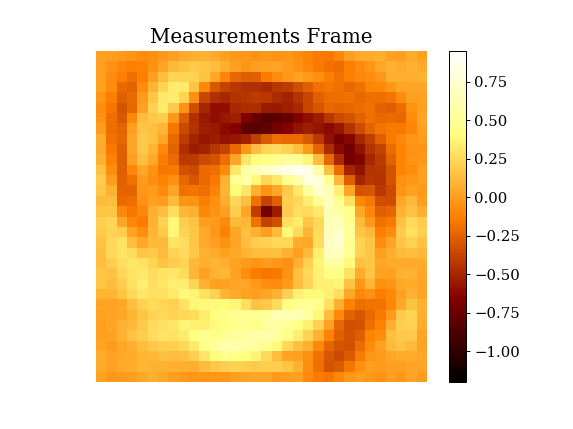

(-0.5, 0.46875, -0.5, 0.46875)

In [131]:
%matplotlib notebook
animation = blurred_movie.reindex(x=blurred_movie.x[::-1]).noisy_methods.get_animation()
plt.title('Measurements Frame', fontsize=16)
plt.axis('off')

Traceback (most recent call last):
  File "/home/aviad/anaconda3/envs/eht/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/home/aviad/anaconda3/envs/eht/lib/python3.7/site-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


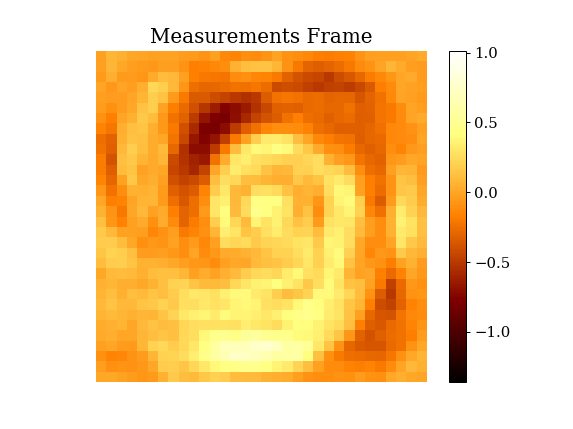

(-0.5, 0.46875, -0.5, 0.46875)

In [130]:
%matplotlib notebook
animation = measurements.noisy_methods.get_animation()
plt.title('Measurements Frame', fontsize=16)
plt.axis('off')

### Compute Residuals
---
Compute residuals using LOBPCG projection residual from precomputed modes and save as a NetCDF dataset

In [6]:
advection = pynoisy.advection.general_xy(nx, ny, opening_angle=-3.)
diffusion = pynoisy.diffusion.general_xy(nx, ny, opening_angle=-1.4)
diffusion.correlation_time[:] = diffusion.correlation_time.mean()
diffusion.correlation_length[:] = diffusion.correlation_length.mean()
advection.magnitude[:] = 0.2
advection.noisy_methods.update_vx_vy()
solver = pynoisy.forward.HGRFSolver(nx, ny, advection, diffusion, seed=27669)

measurements = solver.run(num_frames=nt, n_jobs=4)

In [102]:
advection = pynoisy.advection.general_xy(nx, ny, opening_angle=-np.pi)
diffusion = pynoisy.diffusion.general_xy(nx, ny, opening_angle=-1.0)
diffusion.correlation_time[:] = diffusion.correlation_time.mean()
diffusion.correlation_length[:] = diffusion.correlation_length.mean()
advection.magnitude[:] = 0.2
advection.noisy_methods.update_vx_vy()
solver = pynoisy.forward.HGRFSolver(nx, ny, advection, diffusion, seed=27669)
measurements = solver.run(num_frames=nt, n_jobs=4)

<IPython.core.display.Javascript object>


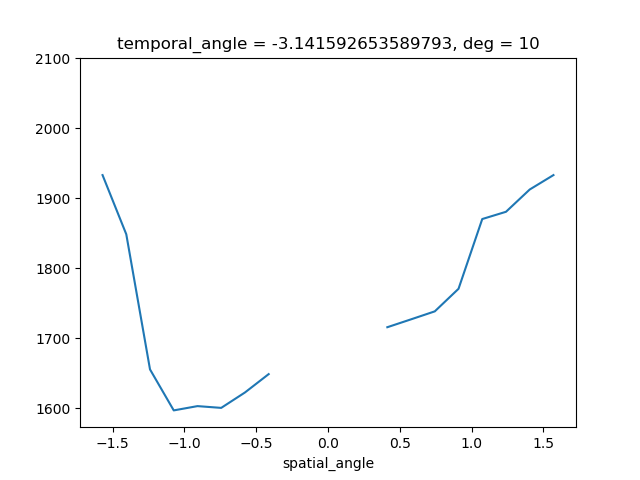

In [108]:
%matplotlib notebook
residuals.isel(temporal_angle=0).squeeze().plot()

In [103]:
def compute_residual_non_orthogonal(files, measurements, degree, scaling=1.0, drop_negatives=True):
    output = []
    for file in tqdm(files, leave=False):
        residual = []
        modes = xr.load_dataset(file)
        for temporal_angle in modes.temporal_angle:
            eigenvectors = modes.sel(temporal_angle=temporal_angle) 
            eigenvalues = eigenvectors.eigenvalues
            if degree < 0:
                degree = eigenvectors.deg.size + degree + 1
                
            if drop_negatives:
                eigenvectors = eigenvectors.where(eigenvectors.eigenvalues > 0.0, drop=True)
                eigenvectors.coords.update({'deg': range(eigenvectors.deg.size)})
                
            eigenvectors = eigenvectors.eigenvectors * scaling
            projection_degree = min(degree, eigenvectors.deg.size)
            projection_matrix = eigenvectors.isel(
                deg=slice(projection_degree)).noisy_methods.get_projection_matrix()
            projection = pynoisy.utils.least_squares_projection(measurements, projection_matrix)
            res = np.linalg.norm(measurements - projection)**2 #- np.sum(np.log(eigenvalues**2))
            res = xr.DataArray(
                [res], dims='temporal_angle',
                coords={'temporal_angle': [temporal_angle]}).expand_dims(
                deg=[degree], spatial_angle=eigenvectors.spatial_angle)
            residual.append(res)
        output.append(xr.concat(residual, dim='temporal_angle').sortby('temporal_angle'))
    output = xr.concat(output, dim='spatial_angle').sortby('spatial_angle')
    return output

In [109]:
residuals = compute_residual_non_orthogonal(files, measurements, degree=10, drop_negatives=False)

# update attributes
residuals.attrs.update(
    file_num=len(files),
    true_temporal_angle=solver.advection.opening_angle,
    true_spatial_angle=solver.diffusion.opening_angle,
    directory=directory, 
    measurement_seed=measurements.seed)

In [90]:
print(residuals.min())
residuals.argmin(dim=['temporal_angle', 'spatial_angle'])

<xarray.DataArray ()>
array(1460.25776284)


{'temporal_angle': <xarray.DataArray (deg: 1)>
 array([4])
 Coordinates:
   * deg      (deg) int64 10, 'spatial_angle': <xarray.DataArray (deg: 1)>
 array([15])
 Coordinates:
   * deg      (deg) int64 10}

<IPython.core.display.Javascript object>


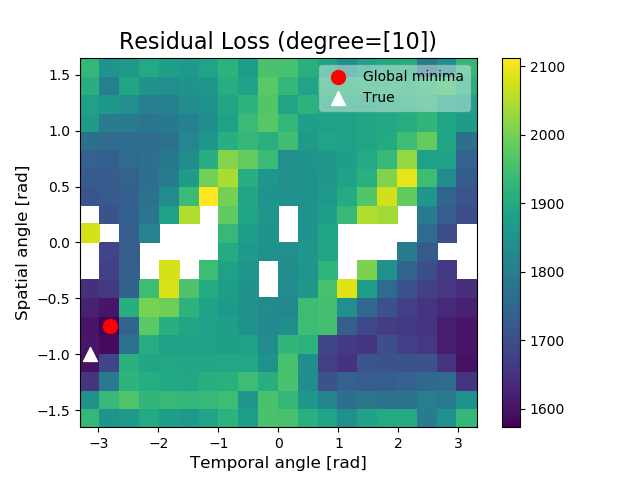

In [110]:
%matplotlib notebook
fig, ax = plt.subplots(1,1)
visualization_2d(residuals, ax, degree=None, contours=False)

<IPython.core.display.Javascript object>


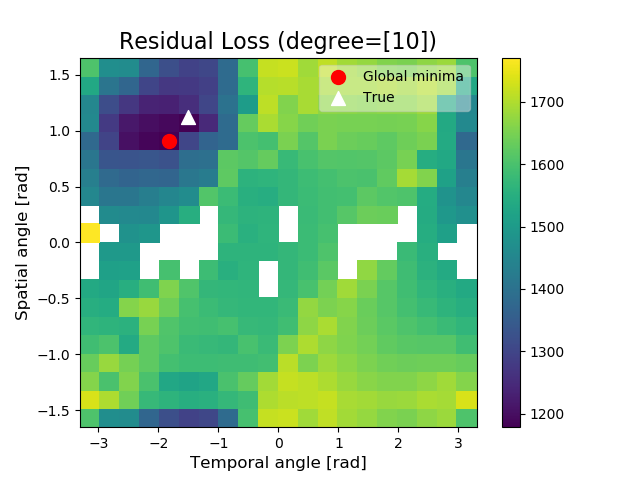

In [71]:
%matplotlib notebook
fig, ax = plt.subplots(1,1)
visualization_2d(residuals, ax, degree=None, contours=False)

<IPython.core.display.Javascript object>


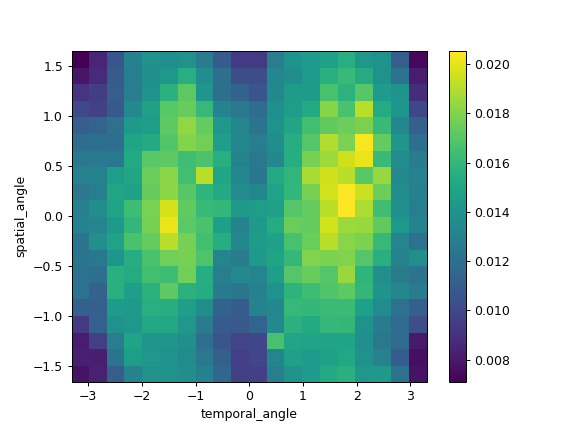

In [8]:
%matplotlib notebook
residuals.plot()

In [ ]:
degrees = [10, 20, -1]
residuals = xr.concat([compute_residual_non_orthogonal(
    files, measurements, deg, scaling=1.0, drop_negatives=True) for deg in degrees], dim='deg')

# update attributes
residuals.attrs = eigenvector.attrs
residuals.attrs.update(
    file_num=len(files),
    true_temporal_angle=solver.advection.opening_angle,
    true_spatial_angle=solver.diffusion.opening_angle,
    directory=directory, 
    measurement_seed=measurements.seed)

In [4]:
advection = pynoisy.advection.general_xy(nx, ny, opening_angle=-1.6)
diffusion = pynoisy.diffusion.general_xy(nx, ny, opening_angle=0.8)

solver = pynoisy.forward.HGRFSolver(nx, ny, advection, diffusion, seed=27669)
measurements = solver.run(num_frames=nt, n_jobs=4, verbose=False)

In [8]:
degrees = [10, 20, 30]
residuals = xr.concat([compute_residual_non_orthogonal(files, measurements, deg) for deg in degrees], dim='deg')

# update attributes
residuals.attrs = eigenvector.attrs
residuals.attrs.update(
    file_num=len(files),
    true_temporal_angle=solver.advection.opening_angle,
    true_spatial_angle=solver.diffusion.opening_angle,
    directory=directory, 
    measurement_seed=measurements.seed)

# Save output NetCDF
residuals.to_netcdf(
    os.path.join(directory, 'residuals.spatial_angle{:1.3}_temporal_angle{:1.3}_{}x{}.nc'.format(
        residuals.true_spatial_angle, residuals.true_temporal_angle, 
        residuals.spatial_angle.size, residuals.temporal_angle.size)))

### Gather statistics

In [68]:
num_grid = 5
degree = 30
drop_negatives = True

#num_seeds = 10
#seed_grid = [np.random.randint(0, 32767) for i in range(num_seeds)]

seed_grid = [27669]
true_spatial_angle = np.linspace(-3.1, 3.1, num_grid)
true_temporal_angle = np.linspace(-1.5, 1.5, num_grid)


residual_stats = []
for seed in tqdm(seed_grid, desc='seed'):
    residual_dataset = []
    for spatial_angle in true_spatial_angle:
        residuals = []
        for temporal_angle in true_temporal_angle:
            advection = pynoisy.advection.general_xy(nx, ny, opening_angle=temporal_angle)
            diffusion = pynoisy.diffusion.general_xy(nx, ny, opening_angle=spatial_angle)
            solver = pynoisy.forward.HGRFSolver(nx, ny, advection, diffusion)
            measurements = solver.run(num_frames=nt, n_jobs=4, verbose=False, seed=seed)
            output = compute_residual_non_orthogonal(files, measurements, degree, drop_negatives=drop_negatives)
            residuals.append(output.expand_dims({
                'seed': [seed],
                'true_temporal_angle': [temporal_angle],
                'true_spatial_angle': [spatial_angle]
            }))
        residual_dataset.append(xr.concat(residuals, dim='true_temporal_angle'))
    residual_stats.append(xr.concat(residual_dataset, dim='true_spatial_angle'))
residual_stats = xr.concat(residual_stats, dim='seed').squeeze()

# update attributes
residual_stats.attrs = eigenvector.attrs
residual_stats.attrs.update(
    file_num=len(files),
    directory=directory,
    drop_negatives = 'True' if drop_negatives else 'False')

# Save output NetCDF
residual_stats.to_netcdf(
    os.path.join(directory, 'residuals.stats.num_spatial{}.num_temporal{}.num_seed{}.{}x{}.nc'.format(
        residual_stats.true_spatial_angle.size, residual_stats.true_temporal_angle.size, 
        residual_stats.seed.size, residual_stats.spatial_angle.size, residual_stats.temporal_angle.size)))

### Load & Visualize Residuals
---

Load and visualize precomputed residuals

<IPython.core.display.Javascript object>


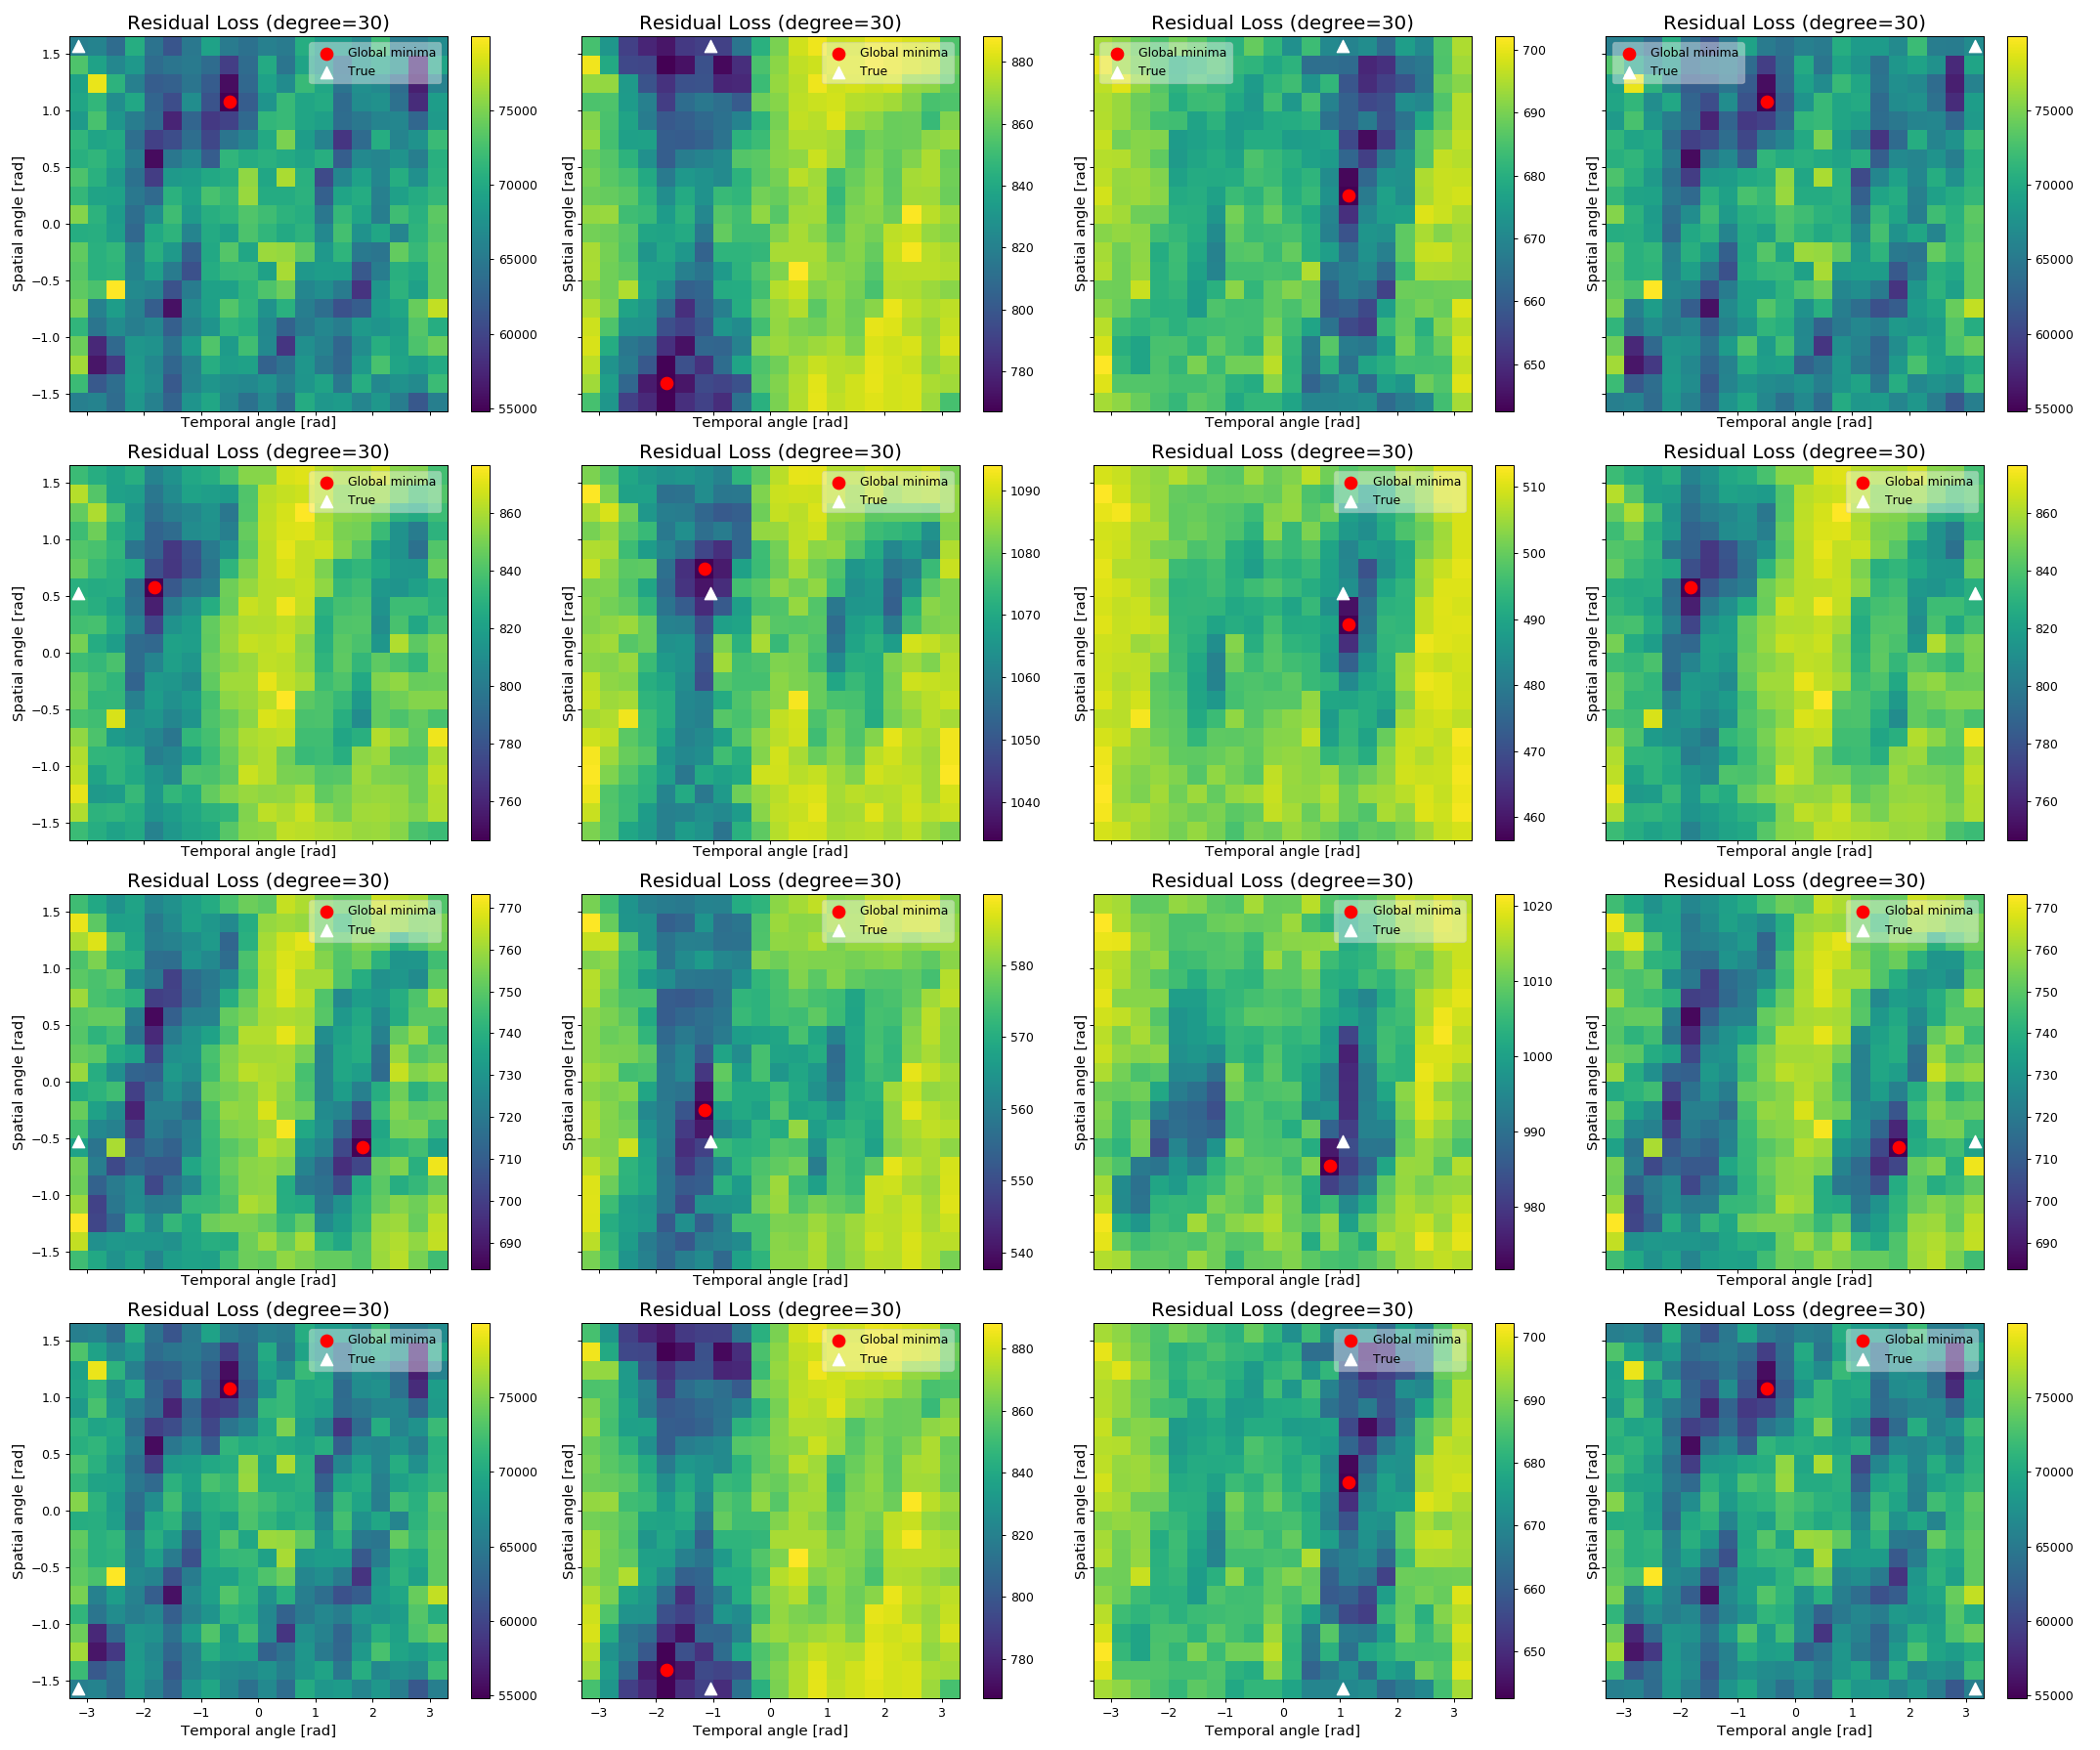

In [69]:
load_path = '../../opening_angle_modes_12-05-2020/residuals.stats.num_spatial4.num_temporal4.num_seed1.20x20.nc'
residuals = xr.load_dataarray(load_path)

num_rows = residuals.true_temporal_angle.size
num_cols = residuals.true_spatial_angle.size
fig, ax = plt.subplots(num_rows, num_cols, figsize=(24,20), sharey=True, sharex=True)
for row in range(num_rows):
    for col in range(num_cols):
        visualization_2d(residuals.isel(true_temporal_angle=row, true_spatial_angle=col), 
                         ax=ax[num_cols-col-1, row])
plt.tight_layout()

In [30]:
load_path = '../../opening_angles_modes_nondeflated/residuals.stats.num_spatial4.num_temporal4.num_seed1.20x20.nc'
residuals = xr.load_dataarray(load_path)

<IPython.core.display.Javascript object>


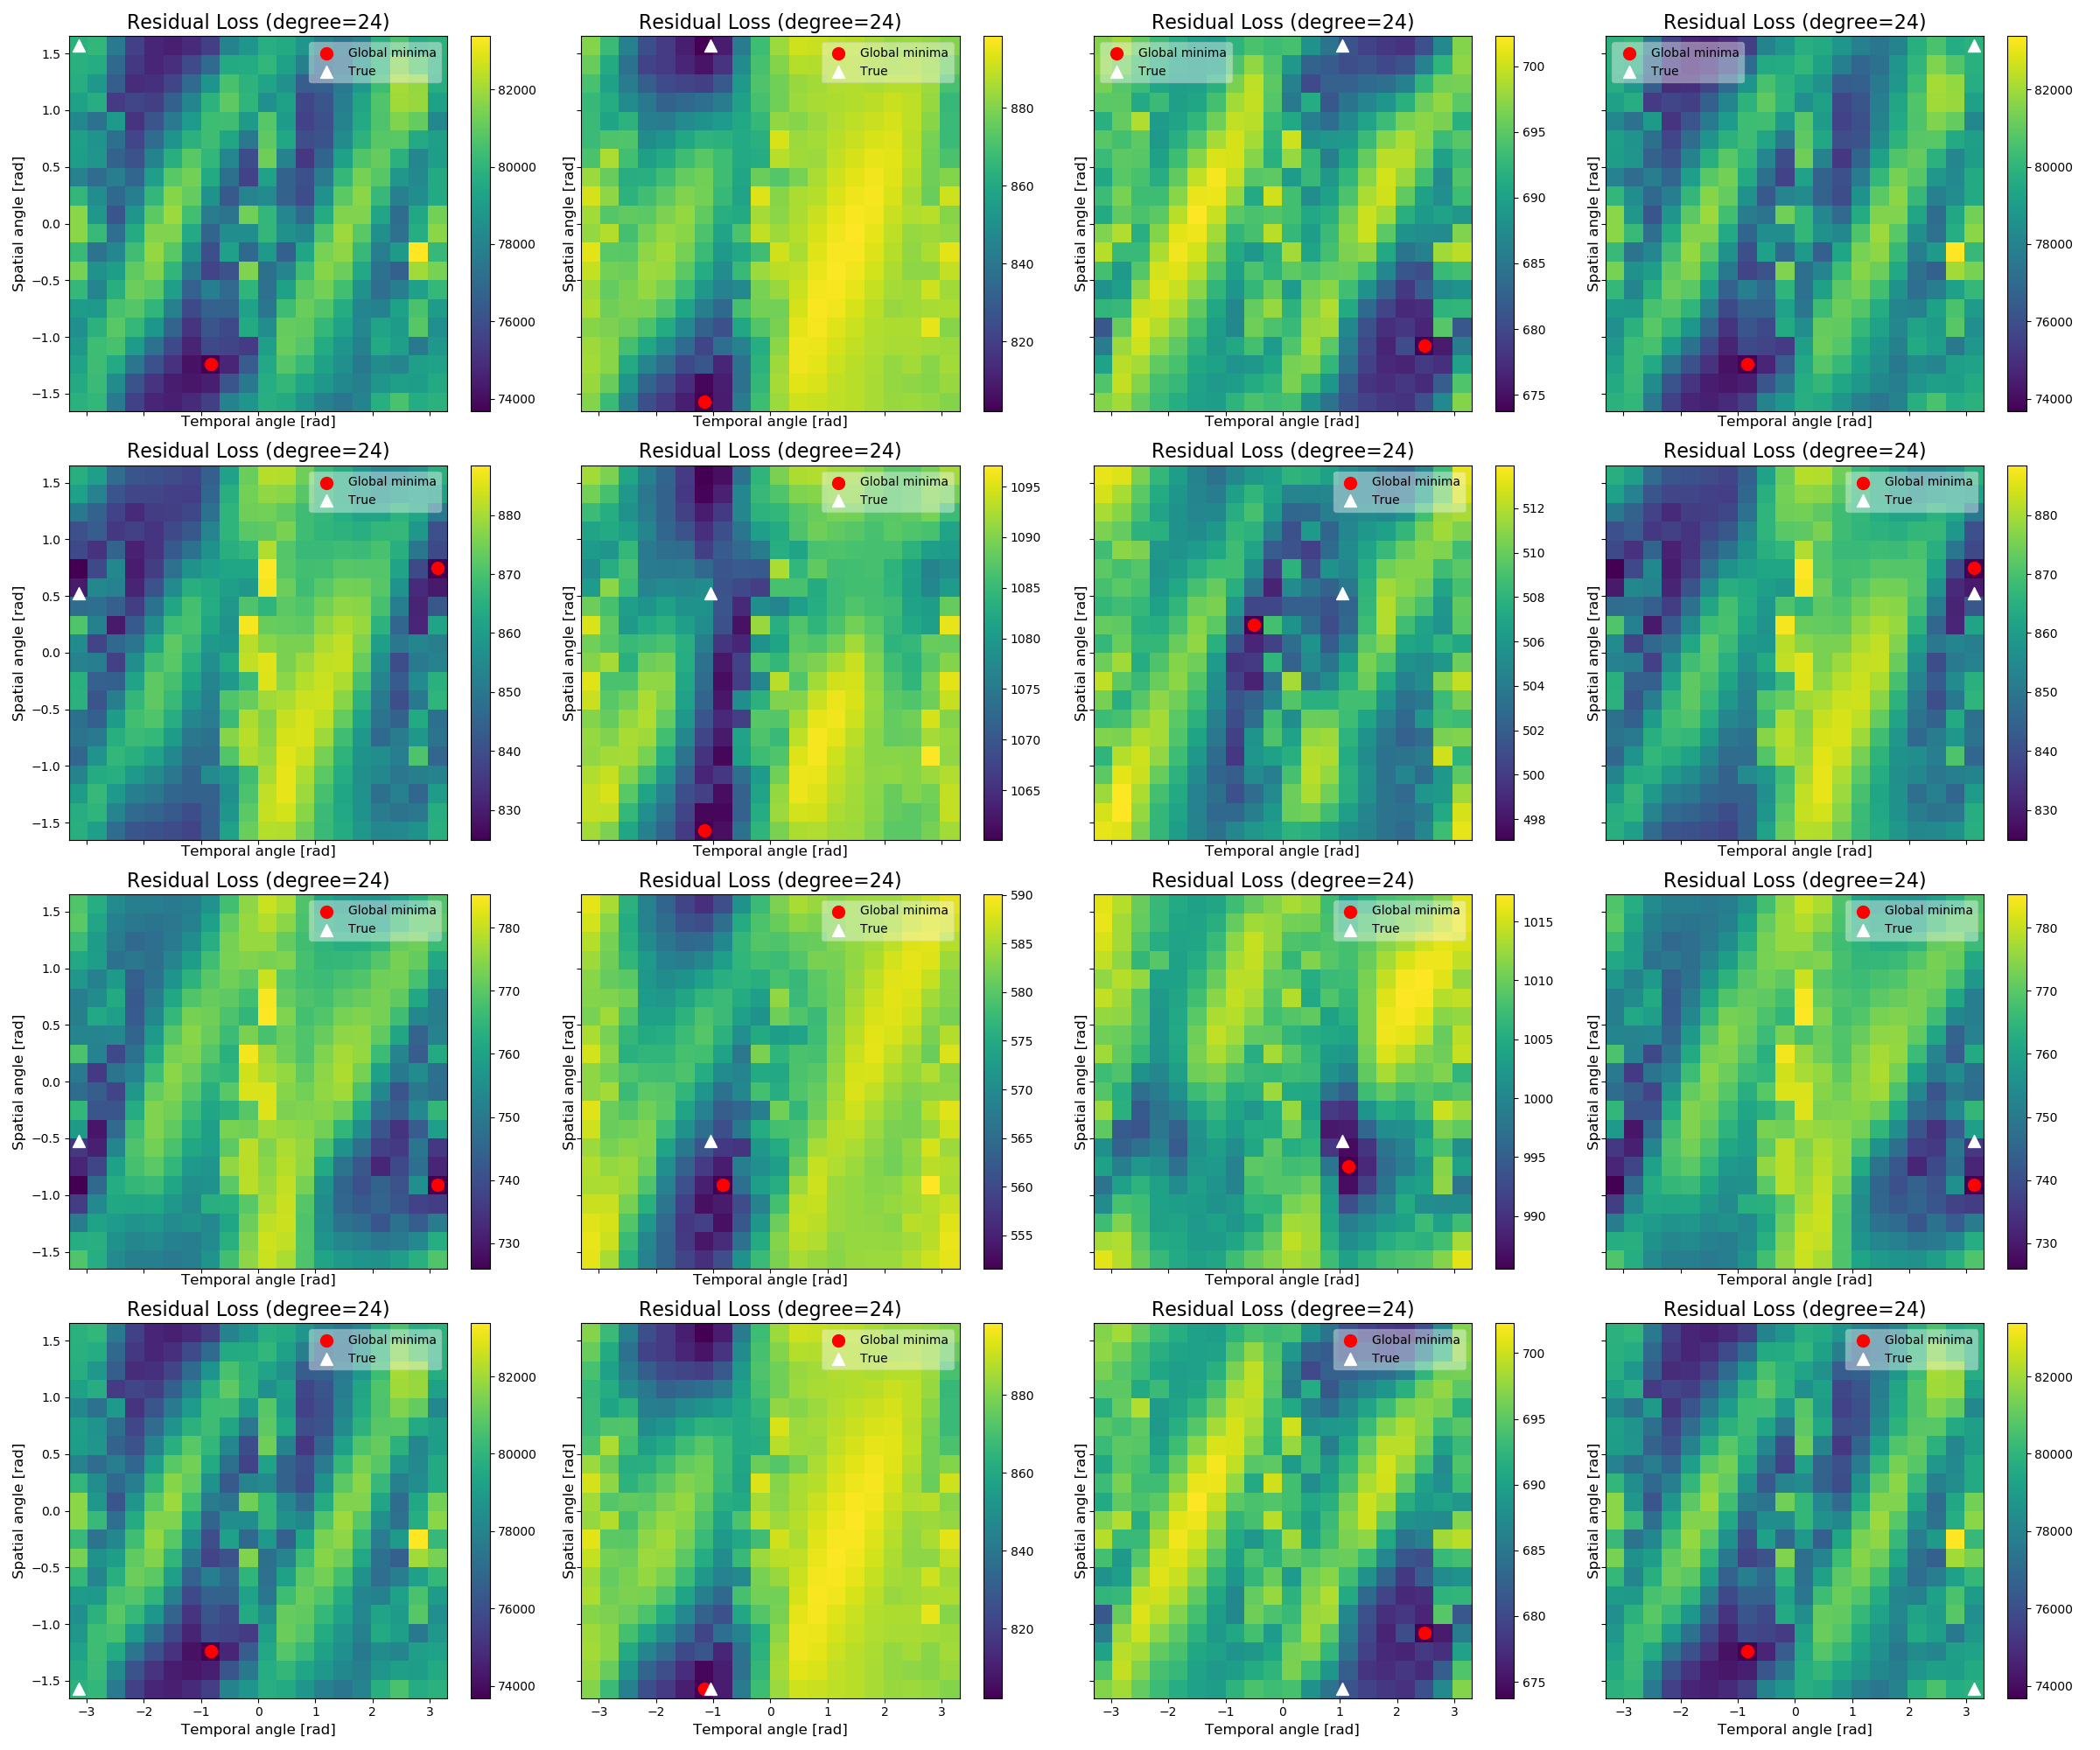

In [66]:
load_path = '../../opening_angles_modes_nondeflated_new/residuals.stats.stdscaled.num_spatial4.num_temporal4.num_seed1.20x20.nc'
residuals = xr.load_dataarray(load_path)

num_rows = residuals.true_temporal_angle.size
num_cols = residuals.true_spatial_angle.size
fig, ax = plt.subplots(num_rows, num_cols, figsize=(24,20), sharey=True, sharex=True)
for row in range(num_rows):
    for col in range(num_cols):
        visualization_2d(residuals.isel(true_temporal_angle=row, true_spatial_angle=col), 
                         ax=ax[num_cols-col-1, row])
plt.tight_layout()

<IPython.core.display.Javascript object>


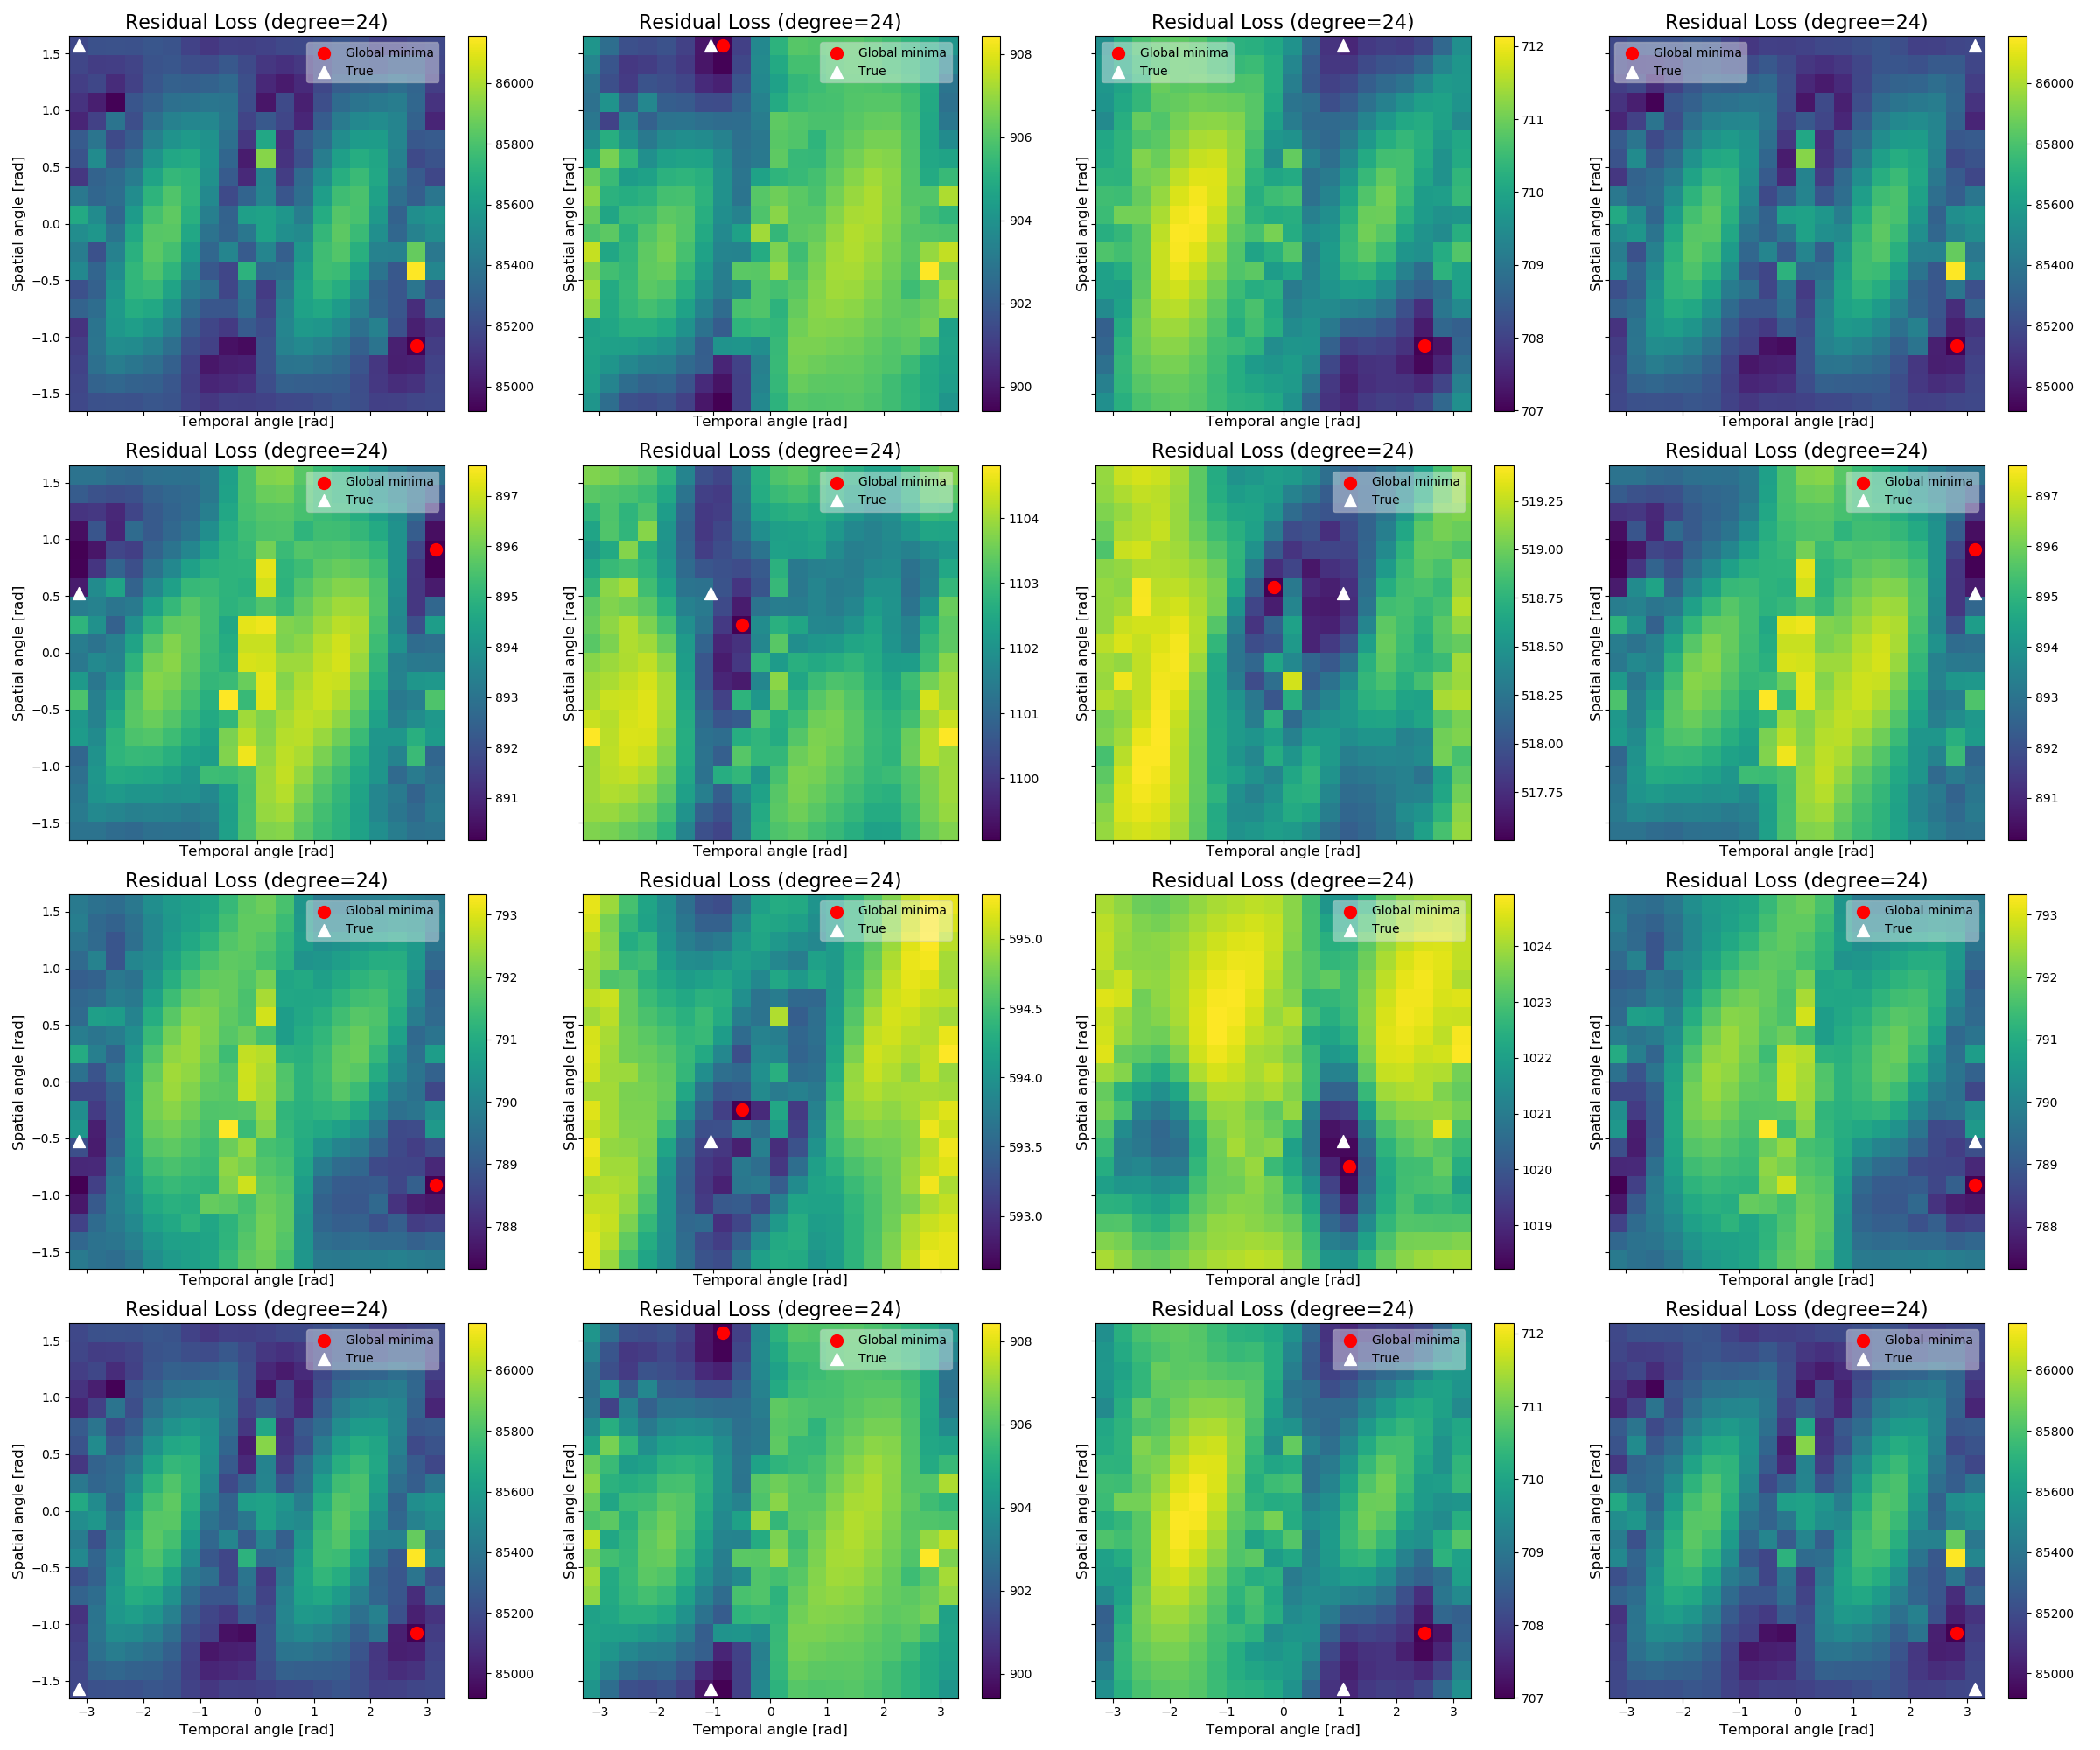

In [64]:
load_path = '../../opening_angles_modes_nondeflated/residuals.stats.num_spatial4.num_temporal4.num_seed1.20x20.nc'
residuals = xr.load_dataarray(load_path)

num_rows = residuals.true_temporal_angle.size
num_cols = residuals.true_spatial_angle.size
fig, ax = plt.subplots(num_rows, num_cols, figsize=(24,20), sharey=True, sharex=True)
for row in range(num_rows):
    for col in range(num_cols):
        visualization_2d(residuals.isel(true_temporal_angle=row, true_spatial_angle=col), 
                         ax=ax[num_cols-col-1, row])
plt.tight_layout()

## GRMHD Measurements
---
General Relativistic Magneto Hydro Dynamics (GRMHD) simulation measurements

### Load Movie

In [18]:
eigenvector.eigenvectors

<xarray.DataArray 'eigenvectors' (deg: 4, t: 64, x: 64, y: 64)>
array([[[[ 4.52266152e-09, -4.19559369e-09,  2.98435012e-09, ...,
           5.03455327e-09,  1.11937473e-09,  2.72763324e-09],
         [-5.04542116e-09,  1.59587998e-09,  3.65666368e-09, ...,
          -1.88927796e-09, -1.35267343e-09, -4.14723319e-09],
         [ 2.65356314e-09,  5.22919171e-09,  6.02935025e-09, ...,
           2.90631959e-09, -6.27116842e-09, -7.53306824e-09],
         ...,
         [ 2.24620586e-09,  2.06827561e-10,  2.23438264e-09, ...,
           1.23221297e-08,  2.81505323e-09, -2.18895810e-09],
         [-1.83422304e-09,  9.76108376e-09, -2.26321798e-09, ...,
           2.92383033e-11,  4.20074989e-09,  5.17803674e-09],
         [ 3.51239142e-09, -3.09720515e-09,  1.48843346e-09, ...,
           1.07418863e-09, -4.78708312e-09,  1.82535678e-09]],

        [[-4.97629227e-09,  7.84060814e-09, -5.89586612e-09, ...,
           1.16650958e-09, -6.19774766e-09, -1.09079708e-08],
         [-5.38221574e-09,  5.61125533e-09,  3.82830948e-09, ...,
          -3.63190242e-09, -7.75027604e-09,  2.78794148e-09],
         [ 2.87072238e-09,  6.21227002e-09,  1.12700845e-08, ...,
          -7.50686448e-10, -2.52425015e-09, -2.08726434e-09],
...
         [-5.35881135e-11,  1.38271600e-08,  1.70761313e-08, ...,
           2.39344528e-08,  1.01276074e-08,  9.81351758e-09],
         [ 4.15751095e-09,  1.14412031e-08,  6.20090860e-10, ...,
           1.81998559e-08,  1.66767455e-08,  7.04035802e-09],
         [ 3.15385999e-09, -5.89838757e-09,  1.78148785e-08, ...,
           5.56543473e-09,  1.78444581e-09, -8.06360393e-10]],

        [[ 1.59979187e-08, -1.70976975e-09, -1.54760221e-09, ...,
           8.71102822e-09,  1.36936658e-09,  2.30500296e-09],
         [-1.60267930e-08,  3.23141036e-08,  1.81616210e-09, ...,
           7.26328384e-09, -1.88486940e-09,  8.69577106e-09],
         [ 1.35066249e-08,  2.05075443e-09,  4.31637221e-08, ...,
           3.96928472e-09,  1.28724791e-09, -1.14322272e-08],
         ...,
         [ 3.39164130e-09,  4.19263587e-09,  1.19053309e-08, ...,
           2.65682024e-08,  1.90483592e-08, -3.21946762e-09],
         [-1.71808109e-09,  3.96268993e-09,  5.09111087e-09, ...,
           1.84163024e-08,  1.12073739e-08,  3.50922555e-09],
         [ 1.41524347e-09,  3.15735618e-09, -4.03927977e-09, ...,
           1.75581779e-08,  9.30771477e-10,  3.18877170e-09]]]])
Coordinates:
  * t        (t) float64 0.0 1.587 3.175 4.762 6.349 ... 95.24 96.83 98.41 100.0
  * x        (x) float64 -0.5 -0.4844 -0.4688 -0.4531 ... 0.4531 0.4688 0.4844
  * y        (y) float64 -0.5 -0.4844 -0.4688 -0.4531 ... 0.4531 0.4688 0.4844
  * deg      (deg) int64 0 1 2 3
    theta    (x, y) float64 -2.356 -2.372 -2.388 -2.405 ... 0.7521 0.769 0.7854
    r        (x, y) float64 0.7071 0.6961 0.6854 0.6748 ... 0.6633 0.6741 0.685

In [4]:
grmhd_directory = '../../GRMHD/'
slider = pynoisy.utils.slider_select_file(grmhd_directory, filetype='h5')

interactive(children=(IntSlider(value=2, description='i', max=5), Output()), _dom_classes=('widget-interact',)…

<IPython.core.display.Javascript object>


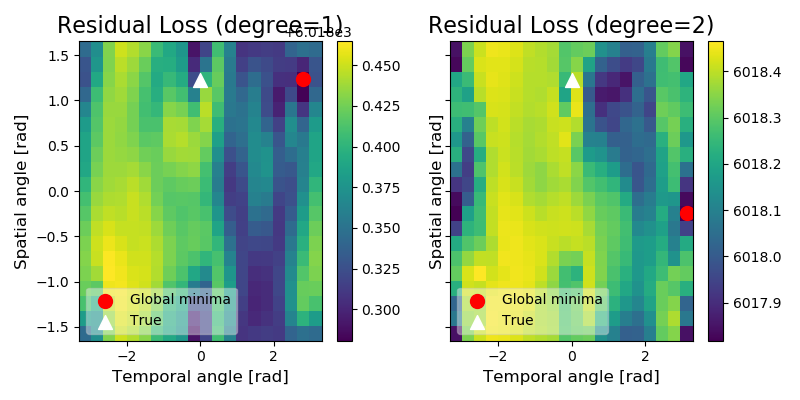

In [47]:
%matplotlib notebook
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
visualization_2d(residuals, ax=ax[0], degree=1)
visualization_2d(residuals, ax=ax[1], degree=2)
plt.tight_layout()

In [5]:
grmhd_movie = pynoisy.utils.load_grmhd(slider.result)
grmhd_movie =  grmhd_movie.interp_like(pynoisy.utils.get_grid(nx, ny))

<IPython.core.display.Javascript object>


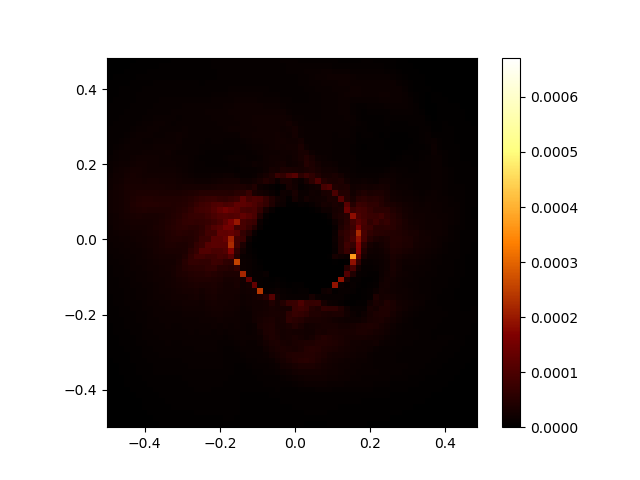

In [6]:
%matplotlib notebook
grmhd_movie.noisy_methods.get_animation()

### Preprocess and Compute Residuals
---
Compute residuals using LOBPCG projection residual from precomputed modes and save as a NetCDF dataset

In [354]:
"""
Preprocessing, use 64 frames of the movie to compute residuals
"""
degree = 24
initial_frame = 200

measurements = grmhd_preprocessing(grmhd_movie, initial_frame, eigenvector.coords)
residuals = compute_residual(files, measurements, degree)

# update attributes
residuals.attrs = eigenvector.attrs
residuals.attrs.update(
    file_num=len(files),
    directory=directory,
    grmhd=slider.result.split('/')[-1],
    initial_frame=initial_frame,
    nx=nx, ny=ny, nt=nt)

# Save output NetCDF
residuals.to_netcdf(os.path.join(directory, 'residuals.{}.initial_frame{}.{}x{}.nc'.format(
    residuals.grmhd, initial_frame, residuals.spatial_angle.size, residuals.temporal_angle.size)))

/home/aviad/anaconda3/envs/eht/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


In [261]:
residual.temporal_angle

<xarray.DataArray 'temporal_angle' (temporal_angle: 20)>
array([-3.141593, -2.810899, -2.480205, -2.149511, -1.818817, -1.488123,
       -1.157429, -0.826735, -0.496041, -0.165347,  0.165347,  0.496041,
        0.826735,  1.157429,  1.488123,  1.818817,  2.149511,  2.480205,
        2.810899,  3.141593])
Coordinates:
  * temporal_angle  (temporal_angle) float64 -3.142 -2.811 -2.48 ... 2.811 3.142

In [ ]:
"""
A sliding window estimate of parameters
"""
initial_frame = 0
final_frame = 1000
degree = 24 

movie = grmhd_movie[initial_frame:final_frame]
residuals = compute_sliding_residual(files, movie, degree)

# update attributes
residuals.attrs = eigenvector.attrs
residuals.attrs.update(
    file_num=len(files),
    directory=directory,
    grmhd=slider.result.split('/')[-1],
    initial_frame=initial_frame,
    final_frame=final_frame,
    nx=nx, ny=ny, nt=nt)

# Save output NetCDF
residuals.to_netcdf(os.path.join(directory, 'residuals.{}.initial_frame{}.final_frame{}.{}x{}.nc'.format(
    residuals.grmhd, initial_frame, final_frame, residuals.spatial_angle.size, residuals.temporal_angle.size)))

In [403]:
eigenvector = solver.get_eigenvectors_deflation(
    degree=4, num_frames=nt, blocksize=2, verbose=1, maxiter=10000, tol=10)

KeyboardInterrupt: 

In [396]:
eigenvector = solver.get_eigenvectors_deflation(
    num_frames=nt, blocksize=1, verbose=1, maxiter=10000, tol=10)

### Load & Visualize Residuals
---

Load and visualize precomputed residuals

In [469]:
"""
Generate GRF sample from infered opening angles
"""
initial_frame = 200
residual_path = '../../opening_angles_modes/residuals.Ma0_inc10.h5.initial_frame{}.20x20.nc'.format(initial_frame)
residuals = xr.load_dataarray(residual_path)
measurements = grmhd_preprocessing(grmhd_movie, initial_frame, eigenvector.coords)
grf = generate_grf_from_residuals(residuals, seed=1709)

/home/aviad/anaconda3/envs/eht/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


<IPython.core.display.Javascript object>


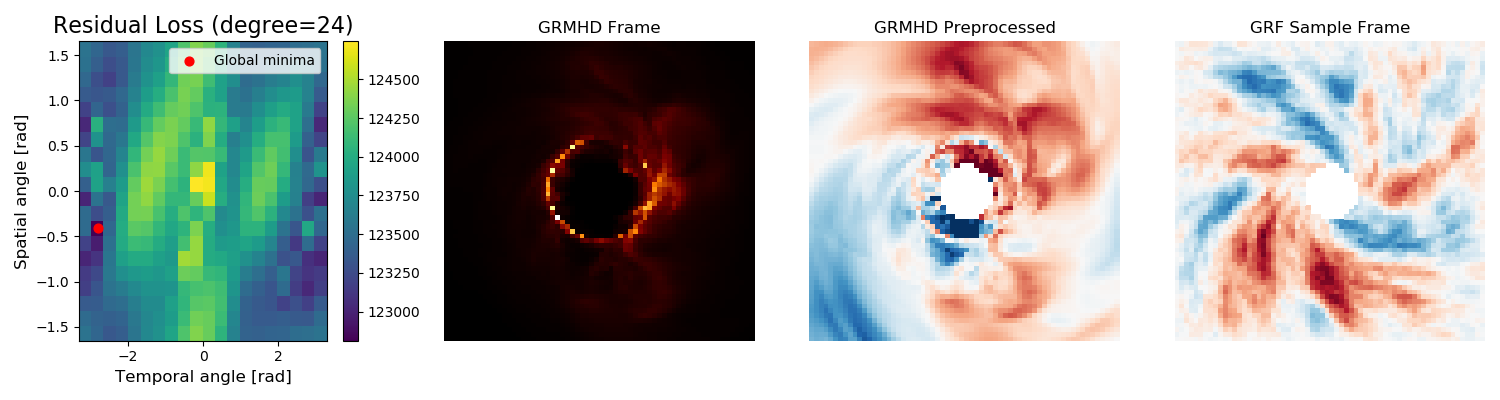

In [470]:
%matplotlib notebook
fig, ax = plt.subplots(1, 4, figsize=(15,4))
visualization_2d(residuals, degree=24, ax=ax[0])

grmhd_movie.isel(t=initial_frame).plot(ax=ax[1], cmap='afmhot', vmin=0, add_colorbar=False)
ax[1].set_title('GRMHD Frame')
ax[1].axis('off')

measurements.isel(t=0).plot(ax=ax[2], vmax=2, add_colorbar=False)
ax[2].set_title('GRMHD Preprocessed')
ax[2].axis('off')

(grf).isel(t=0).where(np.abs(measurements.isel(t=0) )> 0).plot(ax=ax[3], add_colorbar=False)
ax[3].axis('off')
ax[3].set_title('GRF Sample Frame')

plt.tight_layout()

<IPython.core.display.Javascript object>


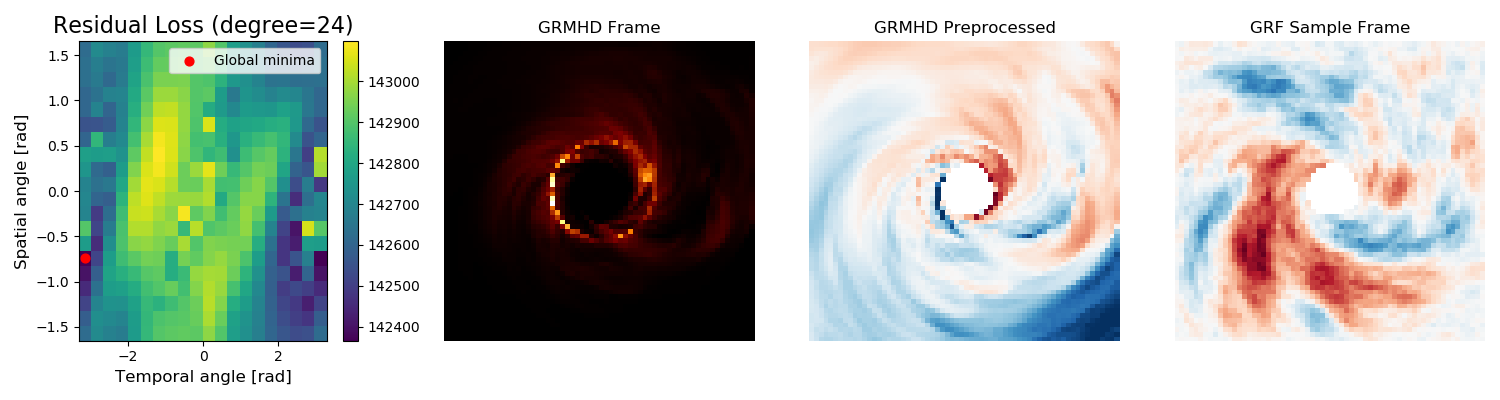

In [459]:
%matplotlib notebook
fig, ax = plt.subplots(1, 4, figsize=(15,4))
visualization_2d(residuals, degree=24, ax=ax[0])

grmhd_movie.isel(t=initial_frame).plot(ax=ax[1], cmap='afmhot', add_colorbar=False)
ax[1].set_title('GRMHD Frame')
ax[1].axis('off')

measurements.isel(t=0).plot(ax=ax[2], vmax=4, add_colorbar=False)
ax[2].set_title('GRMHD Preprocessed')
ax[2].axis('off')

(grf).isel(t=0).where(np.abs(measurements.isel(t=0) )> 0).plot(ax=ax[3], add_colorbar=False)
ax[3].axis('off')
ax[3].set_title('GRF Sample Frame')

plt.tight_layout()

<IPython.core.display.Javascript object>


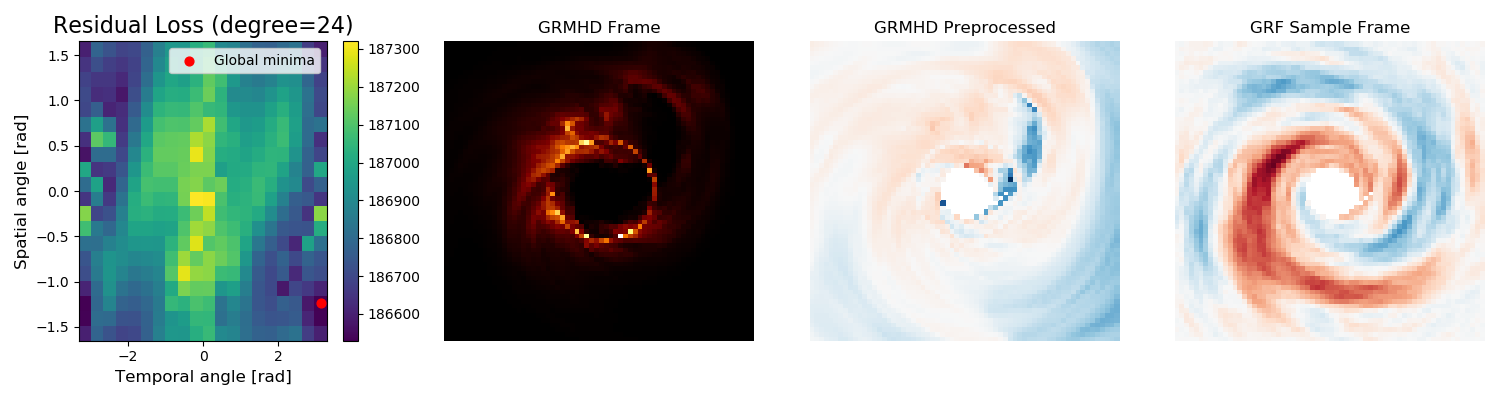

In [407]:
%matplotlib notebook
fig, ax = plt.subplots(1, 4, figsize=(15,4))
visualization_2d(residuals, degree=24, ax=ax[0])

grmhd_movie.isel(t=initial_frame).plot(ax=ax[1], cmap='afmhot', add_colorbar=False)
ax[1].set_title('GRMHD Frame')
ax[1].axis('off')

measurements.isel(t=0).plot(ax=ax[2], add_colorbar=False)
ax[2].set_title('GRMHD Preprocessed')
ax[2].axis('off')

grf.isel(t=0).where(np.abs(measurements.isel(t=0) )> 0).plot(ax=ax[3], add_colorbar=False)
ax[3].axis('off')
ax[3].set_title('GRF Sample Frame')

plt.tight_layout()

#### Sliding window analysis

In [408]:
residual_path = '../../opening_angles_modes/residuals.Ma+0.5_inc10.h5.initial_frame0.final_frame1000.20x20.nc'
residuals = xr.load_dataarray(residual_path)

<IPython.core.display.Javascript object>


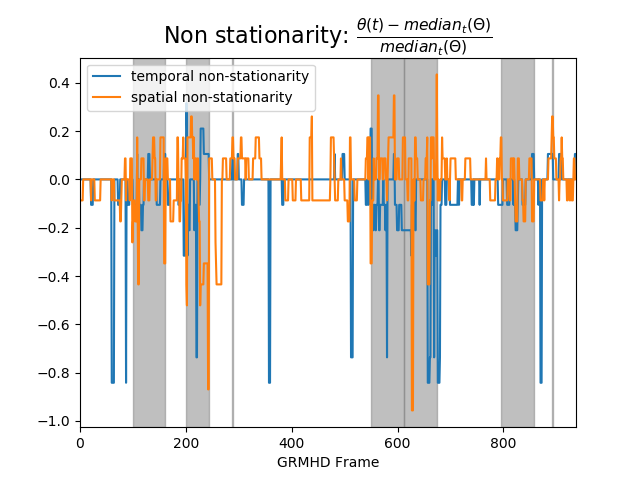

In [310]:
deviation_threshold = 0.3

minimum = residuals[residuals.argmin(dim=['temporal_angle', 'spatial_angle'])]

temporal_angle = np.mod(minimum.temporal_angle + 2*np.pi, 2*np.pi)
spatial_angle = np.mod(minimum.spatial_angle + np.pi, np.pi)

%matplotlib notebook
temporal_nonstationarity = (temporal_angle - temporal_angle.median('initial_frame')) / temporal_angle.median('initial_frame')
temporal_nonstationarity.plot(label='temporal non-stationarity')

spatial_nonstationarity = (spatial_angle - spatial_angle.median('initial_frame')) / spatial_angle.median('initial_frame')
spatial_nonstationarity.plot(label='spatial non-stationarity')

deviations = minimum.where(np.bitwise_and(
    np.abs(temporal_angle - temporal_angle.median('initial_frame')) > deviation_threshold,
    np.abs(spatial_angle - spatial_angle.median('initial_frame')) > deviation_threshold), drop=True)

initial_frames = deviations.initial_frame

# Highlighy regions of non-stationarity
while initial_frames.any():
    region = initial_frames.where(initial_frames < initial_frames[0]+64, drop=True)
    plt.axvspan(region[0], region[-1], color='gray', alpha=0.5) 
    initial_frames = initial_frames.where(initial_frames > region[-1], drop=True)
    
highlight_frame = 205
plt.axvline()
plt.title(r'Non stationarity: $\frac{\theta(t) - median_t(\Theta)}{median_t(\Theta)}$', fontsize=16)
plt.xlim([0, residuals.initial_frame.size])
plt.ylabel(None)
plt.xlabel('GRMHD Frame')
plt.legend()

/home/aviad/anaconda3/envs/eht/lib/python3.7/site-packages/xarray/core/computation.py:700: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


<IPython.core.display.Javascript object>


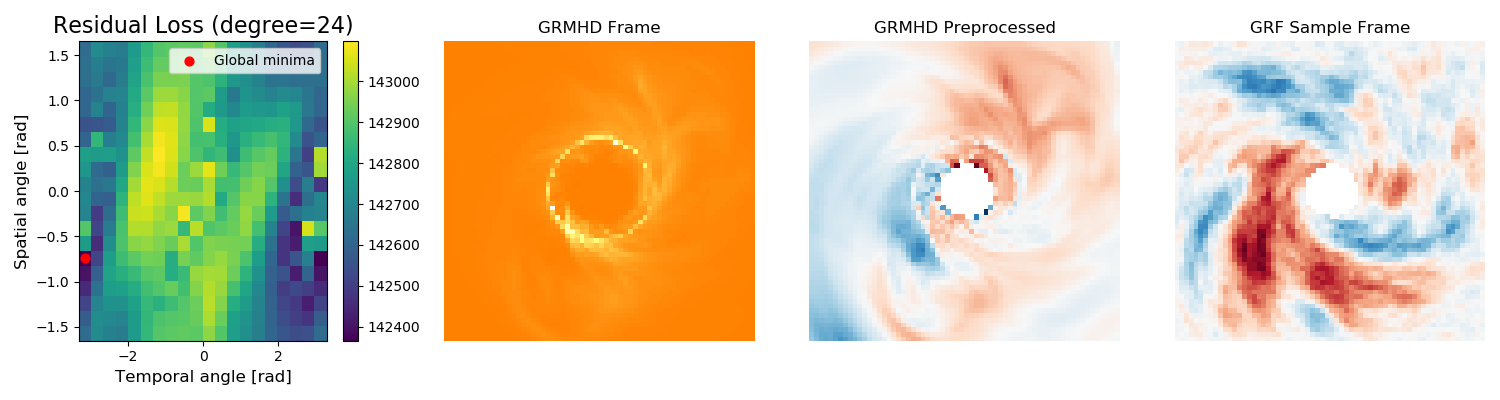

In [461]:
initial_frame = 210
measurements = grmhd_preprocessing(grmhd_movie, initial_frame, eigenvector.coords)
grf = generate_grf_from_residuals(residuals.sel(initial_frame=initial_frame), seed=1709)

%matplotlib notebook
fig, ax = plt.subplots(1, 4, figsize=(15,4))
visualization_2d(residuals.sel(initial_frame=initial_frame), degree=24, ax=ax[0])

grmhd_movie.isel(t=initial_frame).plot(ax=ax[1], cmap='afmhot', add_colorbar=False)
ax[1].set_title('GRMHD Frame')
ax[1].axis('off')

measurements.isel(t=0).plot(ax=ax[2], vmax=4, add_colorbar=False)
ax[2].set_title('GRMHD Preprocessed')
ax[2].axis('off')

(grf).isel(t=0).where(np.abs(measurements.isel(t=0) )> 0).plot(ax=ax[3], add_colorbar=False)
ax[3].axis('off')
ax[3].set_title('GRF Sample Frame')

plt.tight_layout()

In [ ]:
%matplotlib notebook
fig, axes = plt.subplots(1,2, figsize=(10,4))
animation = pynoisy.utils.multiple_animations(
    [measurements, grf.where(np.abs(measurements) > 0)], axes.ravel(), cmaps='viridis', 
    titles=['GRMHD (initial frame={})'.format(initial_frame), 
            r'GRF sample: $\theta_t = {:1.3}~~;~~\theta_x = {:1.3}$'.format(
                grf.temporal_angle, grf.spatial_angle)])

In [51]:
eigenvectors = xr.load_dataset(files[0])
eigenvectors

<xarray.Dataset>
Dimensions:         (deg: 2, spatial_angle: 1, t: 64, temporal_angle: 20, x: 64, y: 64)
Coordinates:
  * spatial_angle   (spatial_angle) float64 -1.571
  * temporal_angle  (temporal_angle) float64 -3.142 -2.811 -2.48 ... 2.811 3.142
  * t               (t) float64 0.0 1.587 3.175 4.762 ... 96.83 98.41 100.0
  * x               (x) float64 -0.5 -0.4844 -0.4688 ... 0.4531 0.4688 0.4844
  * y               (y) float64 -0.5 -0.4844 -0.4688 ... 0.4531 0.4688 0.4844
  * deg             (deg) int64 0 1
Data variables:
    eigenvectors    (spatial_angle, temporal_angle, deg, t, x, y) float64 -2....
    eigenvalues     (spatial_angle, temporal_angle, deg) float64 291.0 ... 768.5
    residuals       (spatial_angle, temporal_angle, deg) float64 1.243e+03 .....
Attributes:
    runname:          [deflated] modes for spatial and temporal opening angles
    file_num:         000 / 019
    date:             27-Nov-2020-13:06:22
    lobpcg_iter:      50
    blocksize:        1
    preconditioning:  False
    seed:             123

In [ ]:
output_path = '../../opening_angles_modes/Ma+0.5_inc10.h5.initial_frame{}.seed{}.comparison.gif'.format(
    initial_frame, grf.seed)
animation.save(output_path, writer='imagemagick')

In [ ]:
"""
Median GRF
"""
advection = pynoisy.advection.general_xy(nx, ny, opening_angle=float(temporal_angle.median('initial_frame')))
diffusion = pynoisy.diffusion.general_xy(nx, ny, opening_angle=float(spatial_angle.median('initial_frame')))
solver = pynoisy.forward.HGRFSolver(nx, ny, advection, diffusion, seed=1709)
median_grf = solver.run(num_frames=nt, n_jobs=4, verbose=False)

<IPython.core.display.Javascript object>


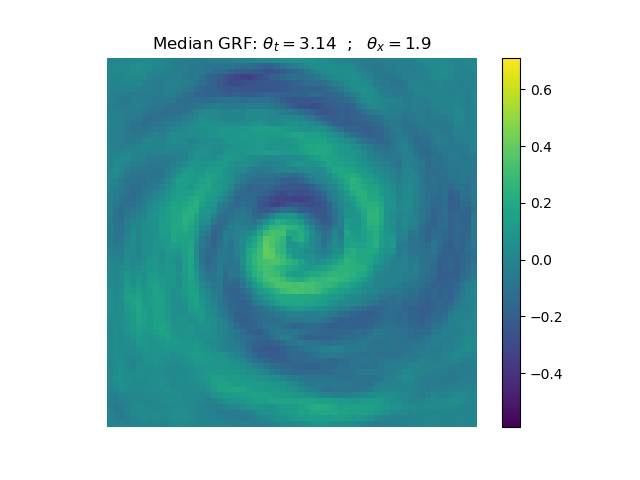

(-0.5, 0.484375, -0.5, 0.484375)

In [344]:
%matplotlib notebook
animation = median_grf.noisy_methods.get_animation(cmap='viridis')
plt.title(r'Median GRF: $\theta_t = {:1.3}~~;~~\theta_x = {:1.3}$'.format
          (advection.opening_angle, diffusion.opening_angle))
plt.axis('off')

In [345]:
output_path = '../../opening_angles_modes/Ma+0.5_inc10.h5.initial_frame{}.seed{}.median_grf.gif'.format(
    initial_frame, grf.seed)
animation.save(output_path, writer='imagemagick')

In [27]:
files

['../../opening_angles_modes/modes.LOBPCGiter50.blocksize1.degree4.precond_False.64x64x64.002.nc',
 '../../opening_angles_modes/modes.LOBPCGiter50.blocksize1.degree4.precond_False.64x64x64.001.nc',
 '../../opening_angles_modes/modes.LOBPCGiter50.blocksize1.degree4.precond_False.64x64x64.016.nc',
 '../../opening_angles_modes/modes.LOBPCGiter50.blocksize1.degree4.precond_False.64x64x64.000.nc',
 '../../opening_angles_modes/modes.LOBPCGiter50.blocksize1.degree4.precond_False.64x64x64.013.nc',
 '../../opening_angles_modes/modes.LOBPCGiter50.blocksize1.degree4.precond_False.64x64x64.007.nc',
 '../../opening_angles_modes/modes.LOBPCGiter50.blocksize1.degree4.precond_False.64x64x64.008.nc',
 '../../opening_angles_modes/modes.LOBPCGiter50.blocksize1.degree4.precond_False.64x64x64.012.nc',
 '../../opening_angles_modes/modes.LOBPCGiter50.blocksize1.degree4.precond_False.64x64x64.014.nc',
 '../../opening_angles_modes/modes.LOBPCGiter50.blocksize1.degree4.precond_False.64x64x64.003.nc',
 '../../op